# Module composition

Given our co-acting gene modules, we will now calculate the composition of those modules - are modules predominantly core, predominantly accessory or mixed.

The strategy we will use will be the following:

1. Given _N_ accessory genes, sample _N_ core genes 100 times
2. For each module in the network, compare the number of accessory genes in the module to the distribution of core gene counts in that module from your 100 samples
    * if the number of accessory genes < 10th quantile of core genes then the module is mostly core
    * if the number of accessory genes > 90th quantile of core genes then the module is mostly accessory
    * else the module is mixed


Explain fisher's exact test***

Here we are comparing the ratio of core/acc within a given module to the ratio of core/acc outside that module.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
method = "affinity"
# num_samples = 100

### Import module memberships

In [3]:
# Import module memberships
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", index_col=0, header=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", index_col=0, header=0)

In [4]:
pao1_membership.head()

,module id
PA0001,390
PA0002,0
PA0003,491
PA0004,298
PA0005,522


In [5]:
pa14_membership.head()

,module id
PA14_55610,425
PA14_55600,168
PA14_55590,425
PA14_55580,379
PA14_55570,189


### Map core/accessory labels to genes

In [6]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [7]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [8]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

### Fisher's exact test

In [9]:
# Get list of modules ids
pao1_module_ids = pao1_membership["module id"].unique()
pa14_module_ids = pa14_membership["module id"].unique()

In [10]:
pao1_gene_group_composition = pd.DataFrame(
    index=pao1_module_ids, columns=["odds ratio", "p-value", "module label"]
)
pa14_gene_group_composition = pd.DataFrame(
    index=pa14_module_ids, columns=["odds ratio", "p-value", "module label"]
)

In [11]:
pao1_gene_group_composition.head()

,odds ratio,p-value,module label
390,NaN,NaN,NaN
0,NaN,NaN,NaN
491,NaN,NaN,NaN
298,NaN,NaN,NaN
522,NaN,NaN,NaN


In [12]:
def label_modules(
    module_ids_list, membership_df, core_genes_list, acc_genes_list, out_df
):
    all_genes = list(membership_df.index)

    for module_id in module_ids_list:
        # For each module create a table
        # -----|inside module|outside module
        # core | # genes     | # genes
        # acc  | # genes     | # genes

        # Find genes in module and outside module
        genes_in_module = list(
            membership_df[membership_df["module id"] == module_id].index
        )
        genes_outside_module = list(set(all_genes).difference(genes_in_module))

        # Get core and accessory in module
        core_genes_in_module = [
            gene for gene in genes_in_module if gene in core_genes_list
        ]
        acc_genes_in_module = [
            gene for gene in genes_in_module if gene in acc_genes_list
        ]

        # Get core and accessory genes outside of module
        core_genes_outside_module = [
            gene for gene in genes_outside_module if gene in core_genes_list
        ]
        acc_genes_outside_module = [
            gene for gene in genes_outside_module if gene in acc_genes_list
        ]

        # Check
        assert len(all_genes) == len(core_genes_in_module) + len(
            acc_genes_in_module
        ) + len(core_genes_outside_module) + len(acc_genes_outside_module)
        assert len(genes_in_module) == len(core_genes_in_module) + len(
            acc_genes_in_module
        )

        # Make contingency table
        observed_contingency_table = np.array(
            [
                [len(core_genes_in_module), len(core_genes_outside_module)],
                [len(acc_genes_in_module), len(acc_genes_outside_module)],
            ]
        )
        odds_ratio, pval = scipy.stats.fisher_exact(
            observed_contingency_table, alternative="two-sided"
        )

        # Fill in df
        out_df.loc[module_id, "odds ratio"] = odds_ratio
        out_df.loc[module_id, "p-value"] = pval

        # Do we want to include odds ratio >1 and significant p-value???
        if odds_ratio > 1 and pval < 0.05:
            out_df.loc[module_id, "module label"] = "mostly core"
        elif odds_ratio < 1 and pval < 0.05:
            out_df.loc[module_id, "module label"] = "mostly accessory"
        else:
            out_df.loc[module_id, "module label"] = "mixed"

    return out_df

In [13]:
%%time
# Get labels for PAO1 compendium
pao1_module_labels = label_modules(
    pao1_module_ids, pao1_membership, pao1_core, pao1_acc, pao1_gene_group_composition
)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [14]:
%%time
# Get labels of PA14 compendium
pa14_module_labels = label_modules(
    pa14_module_ids, pa14_membership, pa14_core, pa14_acc, pa14_gene_group_composition
)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [15]:
pao1_module_labels.head()

,odds ratio,p-value,module label
390,inf,1,mixed
0,inf,1,mixed
491,inf,1,mixed
298,inf,1,mixed
522,inf,1,mixed


### Get matched number of core genes

In [16]:
"""# Sample same number of accessory genes from core genes `num_samples` times
# Store sets of core genes in a df
ls_core_pao1_samples = []
ls_core_pa14_samples = []

num_pao1_acc = len(pao1_acc)
num_pa14_acc = len(pa14_acc)

for i in range(num_samples):
    pao1_sample = random.sample(pao1_core, num_pao1_acc)
    pa14_sample = random.sample(pa14_core, num_pa14_acc)

    ls_core_pao1_samples.append(pao1_sample)
    ls_core_pa14_samples.append(pa14_sample)"""

'# Sample same number of accessory genes from core genes `num_samples` times\n# Store sets of core genes in a df\nls_core_pao1_samples = []\nls_core_pa14_samples = []\n\nnum_pao1_acc = len(pao1_acc)\nnum_pa14_acc = len(pa14_acc)\n\nfor i in range(num_samples):\n    pao1_sample = random.sample(pao1_core, num_pao1_acc)\n    pa14_sample = random.sample(pa14_core, num_pa14_acc)\n\n    ls_core_pao1_samples.append(pao1_sample)\n    ls_core_pa14_samples.append(pa14_sample)'

In [17]:
"""assert len(ls_core_pao1_samples) == num_samples
assert len(ls_core_pa14_samples) == num_samples"""

'assert len(ls_core_pao1_samples) == num_samples\nassert len(ls_core_pa14_samples) == num_samples'

In [18]:
"""assert len(ls_core_pao1_samples[0]) == num_pao1_acc
assert len(ls_core_pa14_samples[0]) == num_pa14_acc"""

'assert len(ls_core_pao1_samples[0]) == num_pao1_acc\nassert len(ls_core_pa14_samples[0]) == num_pa14_acc'

### Calculate composition of modules

In [19]:
"""# Get list of modules ids
pao1_module_ids = pao1_membership["module id"].unique()
pa14_module_ids = pa14_membership["module id"].unique()"""

'# Get list of modules ids\npao1_module_ids = pao1_membership["module id"].unique()\npa14_module_ids = pa14_membership["module id"].unique()'

In [20]:
"""print(len(pao1_module_ids))
print(len(pa14_module_ids))"""

'print(len(pao1_module_ids))\nprint(len(pa14_module_ids))'

In [21]:
"""# For each module get the distribution of number of core genes
pao1_gene_group_composition = pd.DataFrame(
    index=pao1_module_ids, columns=range(0, num_samples)
)
pa14_gene_group_composition = pd.DataFrame(
    index=pa14_module_ids, columns=range(0, num_samples)
)


def get_module_composition(membership_df, core_samples_list, acc_genes, composition_df):
    # Get number of core genes from each sampling per module
    for i in range(len(core_samples_list)):
        num_core_genes = membership_df.loc[core_samples_list[i]][
            "module id"
        ].value_counts()
        composition_df[i] = num_core_genes

    # Get the number of accessory genes per module
    num_acc_genes = membership_df.loc[acc_genes]["module id"].value_counts()
    composition_df["acc"] = num_acc_genes

    composition_df = composition_df.fillna(0)

    return composition_df"""

'# For each module get the distribution of number of core genes\npao1_gene_group_composition = pd.DataFrame(\n    index=pao1_module_ids, columns=range(0, num_samples)\n)\npa14_gene_group_composition = pd.DataFrame(\n    index=pa14_module_ids, columns=range(0, num_samples)\n)\n\n\ndef get_module_composition(membership_df, core_samples_list, acc_genes, composition_df):\n    # Get number of core genes from each sampling per module\n    for i in range(len(core_samples_list)):\n        num_core_genes = membership_df.loc[core_samples_list[i]][\n            "module id"\n        ].value_counts()\n        composition_df[i] = num_core_genes\n\n    # Get the number of accessory genes per module\n    num_acc_genes = membership_df.loc[acc_genes]["module id"].value_counts()\n    composition_df["acc"] = num_acc_genes\n\n    composition_df = composition_df.fillna(0)\n\n    return composition_df'

In [22]:
"""pao1_gene_group_composition_processed = get_module_composition(
    pao1_membership, ls_core_pao1_samples, pao1_acc, pao1_gene_group_composition
)
pa14_gene_group_composition_processed = get_module_composition(
    pa14_membership, ls_core_pa14_samples, pa14_acc, pa14_gene_group_composition
)"""

'pao1_gene_group_composition_processed = get_module_composition(\n    pao1_membership, ls_core_pao1_samples, pao1_acc, pao1_gene_group_composition\n)\npa14_gene_group_composition_processed = get_module_composition(\n    pa14_membership, ls_core_pa14_samples, pa14_acc, pa14_gene_group_composition\n)'

In [23]:
# pao1_gene_group_composition_processed.head()

In [24]:
# pa14_gene_group_composition_processed.head()

In [25]:
"""# For a given module,
# If the number of accessory genes < 10th quantile of core genes then the module is core
# If the number of accessory genes > 90th quantile of core genes then the module is accessory
# Else the module is mixed
def label_modules(module_composition_df):
    core_composition = module_composition_df.drop("acc", axis=1)

    module_composition_df["module label"] = "mixed"
    module_composition_df.loc[
        module_composition_df["acc"] < core_composition.quantile(0.1, axis=1),
        "module label",
    ] = "mostly core"
    module_composition_df.loc[
        module_composition_df["acc"] > core_composition.quantile(0.9, axis=1),
        "module label",
    ] = "mostly accessory"

    return module_composition_df"""

'# For a given module,\n# If the number of accessory genes < 10th quantile of core genes then the module is core\n# If the number of accessory genes > 90th quantile of core genes then the module is accessory\n# Else the module is mixed\ndef label_modules(module_composition_df):\n    core_composition = module_composition_df.drop("acc", axis=1)\n\n    module_composition_df["module label"] = "mixed"\n    module_composition_df.loc[\n        module_composition_df["acc"] < core_composition.quantile(0.1, axis=1),\n        "module label",\n    ] = "mostly core"\n    module_composition_df.loc[\n        module_composition_df["acc"] > core_composition.quantile(0.9, axis=1),\n        "module label",\n    ] = "mostly accessory"\n\n    return module_composition_df'

In [26]:
"""pao1_module_labels = label_modules(pao1_gene_group_composition_processed)
pa14_module_labels = label_modules(pa14_gene_group_composition_processed)"""

'pao1_module_labels = label_modules(pao1_gene_group_composition_processed)\npa14_module_labels = label_modules(pa14_gene_group_composition_processed)'

In [27]:
# pao1_module_labels.head()

In [28]:
# pa14_module_labels.head()

### Examine module composition

In [29]:
pao1_module_labels["module label"].value_counts()

mixed               544
mostly accessory     20
Name: module label, dtype: int64

In [30]:
pa14_module_labels["module label"].value_counts()

mixed               553
mostly accessory     39
mostly core           1
Name: module label, dtype: int64

In [31]:
# Add size of modules to df
pao1_module_labels["size"] = pao1_membership["module id"].value_counts()
pa14_module_labels["size"] = pa14_membership["module id"].value_counts()

In [32]:
pao1_module_labels.head()

,odds ratio,p-value,module label,size
390,inf,1,mixed,12
0,inf,1,mixed,14
491,inf,1,mixed,11
298,inf,1,mixed,10
522,inf,1,mixed,19


In [33]:
pa14_module_labels.head()

,odds ratio,p-value,module label,size
425,inf,0.614116,mixed,11
168,0.790585,0.572192,mixed,9
379,0.790271,0.673723,mixed,18
189,inf,1,mixed,9
255,0.541862,0.287293,mixed,26


Text(0.5, 1.0, 'Size distribution of PAO1 mostly core modules')

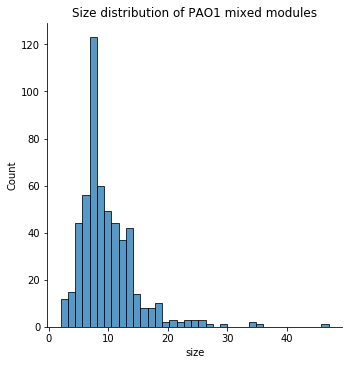

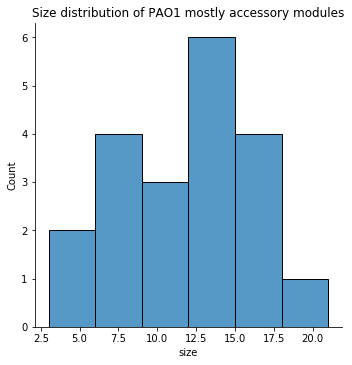

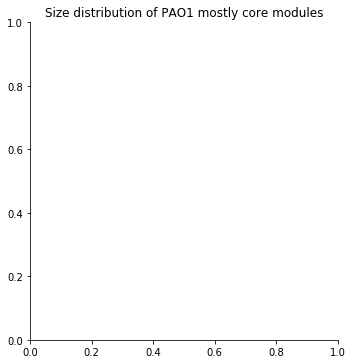

In [34]:
# Size distributions of PAO1 modules
f1 = sns.displot(
    pao1_module_labels.loc[pao1_module_labels["module label"] == "mixed", "size"]
)
plt.title("Size distribution of PAO1 mixed modules")

f2 = sns.displot(
    pao1_module_labels.loc[
        pao1_module_labels["module label"] == "mostly accessory", "size"
    ]
)
plt.title("Size distribution of PAO1 mostly accessory modules")

f3 = sns.displot(
    pao1_module_labels.loc[pao1_module_labels["module label"] == "mostly core", "size"]
)
plt.title("Size distribution of PAO1 mostly core modules")

Text(0.5, 1.0, 'Size distribution of PA14 mostly core modules')

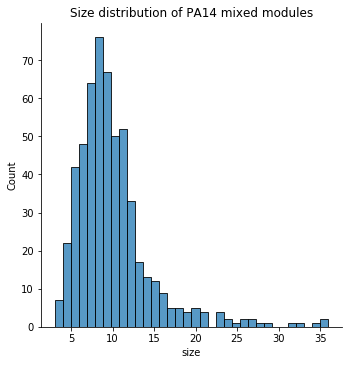

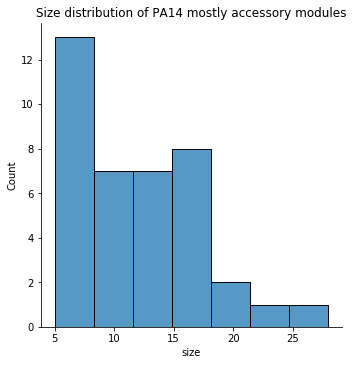

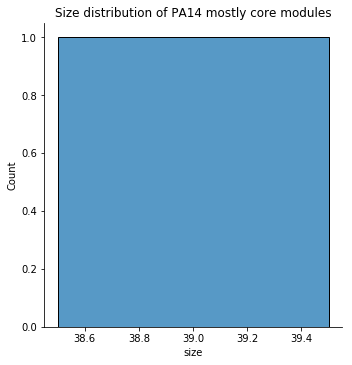

In [35]:
# Size distributions of PA14 moduels
g1 = sns.displot(
    pa14_module_labels.loc[pa14_module_labels["module label"] == "mixed", "size"]
)
plt.title("Size distribution of PA14 mixed modules")

g2 = sns.displot(
    pa14_module_labels.loc[
        pa14_module_labels["module label"] == "mostly accessory", "size"
    ]
)
plt.title("Size distribution of PA14 mostly accessory modules")

g3 = sns.displot(
    pa14_module_labels.loc[pa14_module_labels["module label"] == "mostly core", "size"]
)
plt.title("Size distribution of PA14 mostly core modules")

### Lookup which genes are in which module

TO DO
* Move this into a different notebook?
* Add annotations for KEGG, GO, gene name here

In [36]:
"""pao1_module_labels_truncated = pao1_module_labels[["module label", "size"]]
pa14_module_labels_truncated = pa14_module_labels[["module label", "size"]]"""

'pao1_module_labels_truncated = pao1_module_labels[["module label", "size"]]\npa14_module_labels_truncated = pa14_module_labels[["module label", "size"]]'

In [37]:
"""# Map genes to modules to labels
pao1_gene_module_labels = pao1_membership.merge(
    pao1_module_labels_truncated, left_on="module id", right_index=True
)
pa14_gene_module_labels = pa14_membership.merge(
    pa14_module_labels_truncated, left_on="module id", right_index=True
)"""

'# Map genes to modules to labels\npao1_gene_module_labels = pao1_membership.merge(\n    pao1_module_labels_truncated, left_on="module id", right_index=True\n)\npa14_gene_module_labels = pa14_membership.merge(\n    pa14_module_labels_truncated, left_on="module id", right_index=True\n)'

In [38]:
"""# Save
pao1_gene_module_labels.to_csv(
    os.path.join(
        paths.LOCAL_DATA_DIR, "pao1_gene_module_labels.tsv"
    ),
    sep="\t"
)
pa14_gene_module_labels.to_csv(
    os.path.join(
        paths.LOCAL_DATA_DIR, "pa14_gene_module_labels.tsv"
    ),
    sep="\t"
)"""

'# Save\npao1_gene_module_labels.to_csv(\n    os.path.join(\n        paths.LOCAL_DATA_DIR, "pao1_gene_module_labels.tsv"\n    ),\n    sep="\t"\n)\npa14_gene_module_labels.to_csv(\n    os.path.join(\n        paths.LOCAL_DATA_DIR, "pa14_gene_module_labels.tsv"\n    ),\n    sep="\t"\n)'

In [39]:
# TO DO: Compare the composition across partitions
# Save the matrix that maps module id to module label per partition
# In another notebook look through module labels per partition
# Calculate consistency of labeling using ARI for each pair of partitions

**Takeaway:**
* Most modules are mixed, some are mostly accessory. Only PA14 compendium have some mostly core modules
* PAO1 mixed and mostly accessory modules have similar sizes (~10 genes)
* PA14 mixed modules are ~10 genes, mostly accessory modules are smaller ~5 genes, mostly core modules are larger ~ 20 genes